
Figure D-2: Clustering Evaluation (Hierarchical)


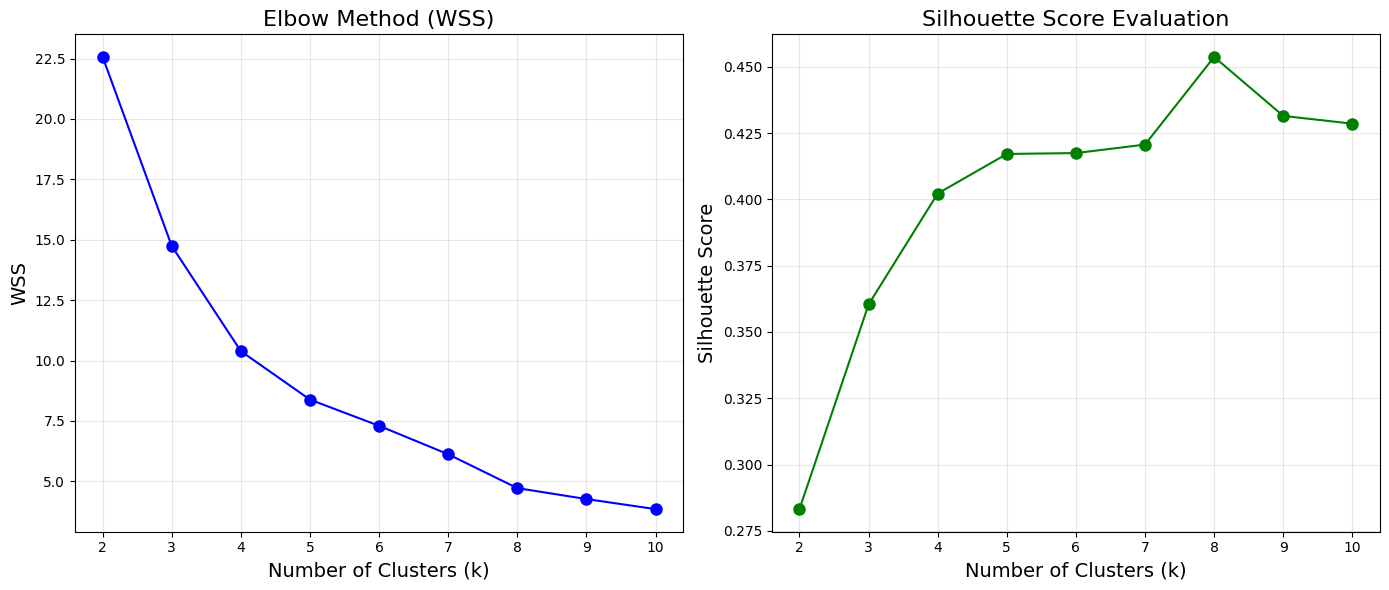


Table D-2: Hierarchical Clustering Metrics
   Clusters (k)     WSS  Silhouette Score
0             2  22.567             0.283
1             3  14.736             0.360
2             4  10.387             0.402
3             5   8.382             0.417
4             6   7.297             0.417
5             7   6.119             0.421
6             8   4.718             0.454
7             9   4.266             0.431
8            10   3.849             0.429

 Figure D-3


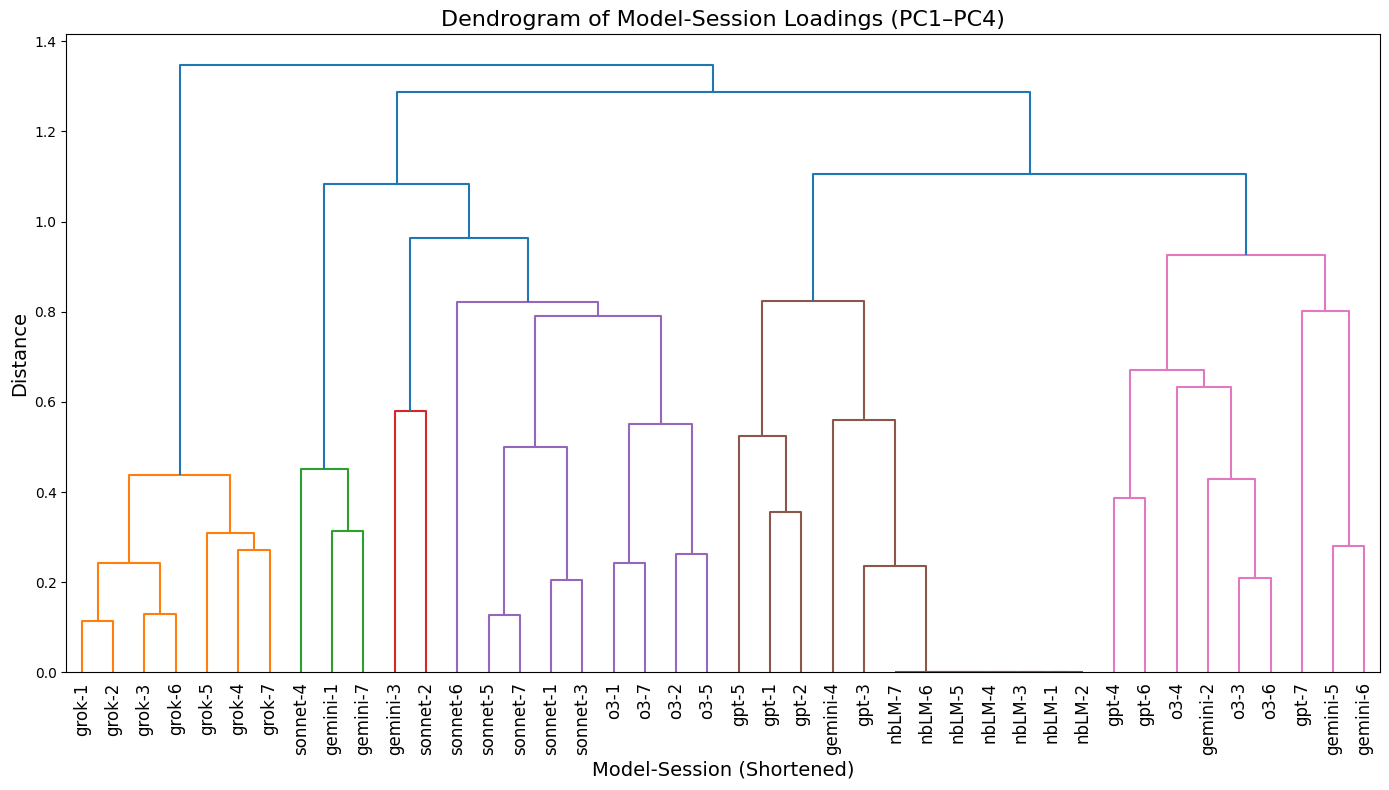


Hierarchical Clustering Assignment (k=5):
Cluster 1: ['grok-1' 'grok-2' 'grok-3' 'grok-4' 'grok-5' 'grok-6' 'grok-7']
Cluster 2: ['gemini-1' 'gemini-7' 'sonnet-4']
Cluster 3: ['gemini-3' 'o3-1' 'o3-2' 'o3-5' 'o3-7' 'sonnet-1' 'sonnet-2' 'sonnet-3'
 'sonnet-5' 'sonnet-6' 'sonnet-7']
Cluster 4: ['gpt-1' 'gpt-2' 'gpt-3' 'gpt-5' 'gemini-4' 'nbLM-1' 'nbLM-2' 'nbLM-3'
 'nbLM-4' 'nbLM-5' 'nbLM-6' 'nbLM-7']
Cluster 5: ['gpt-4' 'gpt-6' 'gpt-7' 'gemini-2' 'gemini-5' 'gemini-6' 'o3-3' 'o3-4'
 'o3-6']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load CSV
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Pivot to wide format
df_cross = (
    df.set_index(['story', 'model', 'session'])['score']
      .unstack(['model', 'session'])
      .reset_index()
)

# Rename columns
df_cross.columns = [
    col if isinstance(col, str) else f"{col[0]}-{col[1]}"
    for col in df_cross.columns
]

# Prepare PCA input
story_titles = df_cross['story-'].values
X = df_cross.drop('story-', axis=1).values
feature_names = df_cross.columns[1:].tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Format loadings
max_pcs = min(4, len(feature_names))
loadings_df = pd.DataFrame(
    loadings[:, :max_pcs],
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(max_pcs)]
).reset_index().rename(columns={'index': 'label'})

# Shorten model names
unique_models = loadings_df['label'].str.rsplit('-', n=1).str[0].unique()
model_short_names = {}
for model in unique_models:
    if 'GPT' in model:
        model_short_names[model] = 'gpt'
    elif 'Gemini' in model:
        model_short_names[model] = 'gemini'
    elif 'Notebook' in model:
        model_short_names[model] = 'nbLM'
    elif 'Open' in model:
        model_short_names[model] = 'o3'
    elif 'Grok' in model:
        model_short_names[model] = 'grok'
    elif 'Sonnet' in model:
        model_short_names[model] = 'sonnet'
    else:
        model_short_names[model] = model

loadings_df['label'] = loadings_df['label'].apply(
    lambda x: model_short_names[x.rsplit('-', 1)[0]] + x[-2:]
)

# Prepare matrix
X = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']].values

# Hierarchical clustering
Z = linkage(X, method='average')

# Evaluate clusters for k=2~10
k_range = range(2, 11)
silhouette_scores = []
wss_equivalent = []

for k in k_range:
    labels = fcluster(Z, k, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X, labels))

    wss = 0
    for i in range(1, k + 1):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
            wss += np.sum(np.square(cluster_points - centroid))
    wss_equivalent.append(wss)

# Plot evaluation metrics
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, wss_equivalent, 'o-', color='blue', markersize=8)
plt.title('Elbow Method (WSS)', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('WSS', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', color='green', markersize=8)
plt.title('Silhouette Score Evaluation', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
print("\nFigure D-2: Clustering Evaluation (Hierarchical)")
plt.show()

# Display table
df_metrics = pd.DataFrame({
    'Clusters (k)': list(k_range),
    'WSS': wss_equivalent,
    'Silhouette Score': silhouette_scores
}).round(3)

print("\nTable D-2: Hierarchical Clustering Metrics")
print(df_metrics)
print("\n Figure D-3")

# Dendrogram
plt.figure(figsize=(14, 8))
plt.title('Dendrogram of Model-Session Loadings (PC1–PC4)', fontsize=16)
plt.xlabel('Model-Session (Shortened)', fontsize=14)
plt.ylabel('Distance', fontsize=14)

dendrogram(Z, labels=loadings_df['label'].values, leaf_rotation=90)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

# Cluster assignment at k=5
n_clusters = 5
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
loadings_df['cluster'] = cluster_labels

# Show members per cluster
print("\nHierarchical Clustering Assignment (k=5):")
for i in range(1, n_clusters + 1):
    members = loadings_df[loadings_df['cluster'] == i]['label'].values
    print(f"Cluster {i}: {members}")
